# **PROBLEM STATEMENT**

Topic Modeling for Research Articles 2.0 Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more and more difficult. Tagging or topic modelling provides a way to give clear token of identification to research articles which facilitates recommendation and search process.

Earlier on the Independence Day we conducted a Hackathon to predict the topics for each article included in the test set. Continuing with the same problem, In this Live Hackathon we will take one more step ahead and predict the tags associated with the articles.

Given the abstracts for a set of research articles, predict the tags for each article included in the test set. Note that a research article can possibly have multiple tags. The research article abstracts are sourced from the following 4 topics:

Computer Science

Mathematics

Physics

Statistics

List of possible tags are as follows:

[Tags, Analysis of PDEs, Applications, Artificial Intelligence,Astrophysics of Galaxies, Computation and Language, Computer Vision and Pattern Recognition, Cosmology and Nongalactic Astrophysics, Data Structures and Algorithms, Differential Geometry, Earth and Planetary Astrophysics, Fluid Dynamics,Information Theory, Instrumentation and Methods for Astrophysics, Machine Learning, Materials Science, Methodology, Number Theory, Optimization and Control, Representation Theory, Robotics, Social and Information Networks, Statistics Theory, Strongly Correlated Electrons, Superconductivity, Systems and Control]



In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from nltk.stem import WordNetLemmatizer 
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import warnings
warnings.simplefilter('ignore')

In [18]:
train = pd.read_csv(r"C:\Users\rishi\Desktop\GIM\Hackathons\Hacklive_3\Train.csv")
test = pd.read_csv(r"C:\Users\rishi\Desktop\GIM\Hackathons\Hacklive_3\Test.csv")
ss = pd.read_csv(r"C:\Users\rishi\Desktop\GIM\Hackathons\Hacklive_3\SampleSubmission_Uqu2HVA.csv")
tags = pd.read_csv(r"C:\Users\rishi\Desktop\GIM\Hackathons\Hacklive_3\Tags.csv")

# **EDA**

### **1. Brief look at the dataset**.

In [3]:
train.head()
test.head()
tags.head()

,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
0,1824,a ever-growing datasets inside observational a...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3094,we propose the framework considering optimal $...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,8463,nanostructures with open shell transition meta...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2082,stars are self-gravitating fluids inside which...,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8687,deep neural perception and control networks ar...,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,id,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
0,9409,fundamental frequency (f0) approximation from ...,0,0,0,1
1,17934,"this large-scale study, consisting of 24.5 mil...",1,0,0,1
2,16071,we present a stability analysis of the plane c...,0,0,1,0
3,16870,we construct finite time blow-up solutions to ...,0,1,0,0
4,10496,planetary nebulae (pne) constitute an importan...,0,0,1,0


,Tags
0,Analysis of PDEs
1,Applications
2,Artificial Intelligence
3,Astrophysics of Galaxies
4,Computation and Language


In [19]:
ID_COL = 'id'

TARGET_COLS = ['Analysis of PDEs', 'Applications',
               'Artificial Intelligence', 'Astrophysics of Galaxies',
               'Computation and Language', 'Computer Vision and Pattern Recognition',
               'Cosmology and Nongalactic Astrophysics',
               'Data Structures and Algorithms', 'Differential Geometry',
               'Earth and Planetary Astrophysics', 'Fluid Dynamics',
               'Information Theory', 'Instrumentation and Methods for Astrophysics',
               'Machine Learning', 'Materials Science', 'Methodology', 'Number Theory',
               'Optimization and Control', 'Representation Theory', 'Robotics',
               'Social and Information Networks', 'Statistics Theory',
               'Strongly Correlated Electrons', 'Superconductivity',
               'Systems and Control']

TOPIC_COLS = ['Computer Science', 'Mathematics', 'Physics', 'Statistics']

### **2. Dataset Shape (Number of Samples and Variables in the dataset)**

In [5]:
print(f'\n->->->| Train contains {train.shape[0]} samples and {train.shape[1]} variables')
print(f'\n->->->| Test contains {test.shape[0]} samples and {test.shape[1]} variables')
print(f'\n->->->| Number of distinct SUB TOPICS is {len(TARGET_COLS)}')

features = [c for c in train.columns if c not in [ID_COL] + TARGET_COLS]
print(f'\n->->->| The dataset contains {len(features)} features')


->->->| Train contains 14004 samples and 31 variables

->->->| Test contains 6002 samples and 6 variables

->->->| Number of distinct SUB TOPICS is 25

->->->| The dataset contains 5 features


### **3.Target Distribution**

In [152]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

### **4. Null Values**

In [153]:
null_values_per_variable = 100 * (train.isnull().sum()/train.shape[0]).round(3)#.reset_index()
null_values_per_variable.sort_values(ascending=False)

Systems and Control                             0.0
Differential Geometry                           0.0
ABSTRACT                                        0.0
Computer Science                                0.0
Mathematics                                     0.0
Physics                                         0.0
Statistics                                      0.0
Analysis of PDEs                                0.0
Applications                                    0.0
Artificial Intelligence                         0.0
Astrophysics of Galaxies                        0.0
Computation and Language                        0.0
Computer Vision and Pattern Recognition         0.0
Cosmology and Nongalactic Astrophysics          0.0
Data Structures and Algorithms                  0.0
Earth and Planetary Astrophysics                0.0
Superconductivity                               0.0
Fluid Dynamics                                  0.0
Information Theory                              0.0
Instrumentat

### **6. Unique values in each variable**

In [154]:
train.nunique()

id                                              14004
ABSTRACT                                        14004
Computer Science                                    2
Mathematics                                         2
Physics                                             2
Statistics                                          2
Analysis of PDEs                                    2
Applications                                        2
Artificial Intelligence                             2
Astrophysics of Galaxies                            2
Computation and Language                            2
Computer Vision and Pattern Recognition             2
Cosmology and Nongalactic Astrophysics              2
Data Structures and Algorithms                      2
Differential Geometry                               2
Earth and Planetary Astrophysics                    2
Fluid Dynamics                                      2
Information Theory                                  2
Instrumentation and Methods 

In [155]:
train[TOPIC_COLS].sum().sort_values(ascending=False)

Computer Science    5884
Physics             3856
Statistics          3794
Mathematics         2831
dtype: int64

In [156]:
100 * (train[TARGET_COLS].sum()/(train.shape[0])).sort_values(ascending=False)

Machine Learning                                27.313625
Artificial Intelligence                          9.825764
Robotics                                         6.812339
Computer Vision and Pattern Recognition          6.705227
Strongly Correlated Electrons                    6.376750
Materials Science                                5.534133
Computation and Language                         4.605827
Cosmology and Nongalactic Astrophysics           4.520137
Optimization and Control                         4.434447
Social and Information Networks                  4.420166
Analysis of PDEs                                 4.334476
Applications                                     4.227364
Astrophysics of Galaxies                         4.098829
Methodology                                      4.098829
Systems and Control                              4.041702
Differential Geometry                            3.963153
Superconductivity                                3.870323
Statistics The

## **VISUAL EDA THROUGH WORDCLOUDS**

In [7]:
from wordcloud import WordCloud, STOPWORDS
wc = WordCloud(stopwords = set(list(STOPWORDS) + ['inside']), random_state = 42)

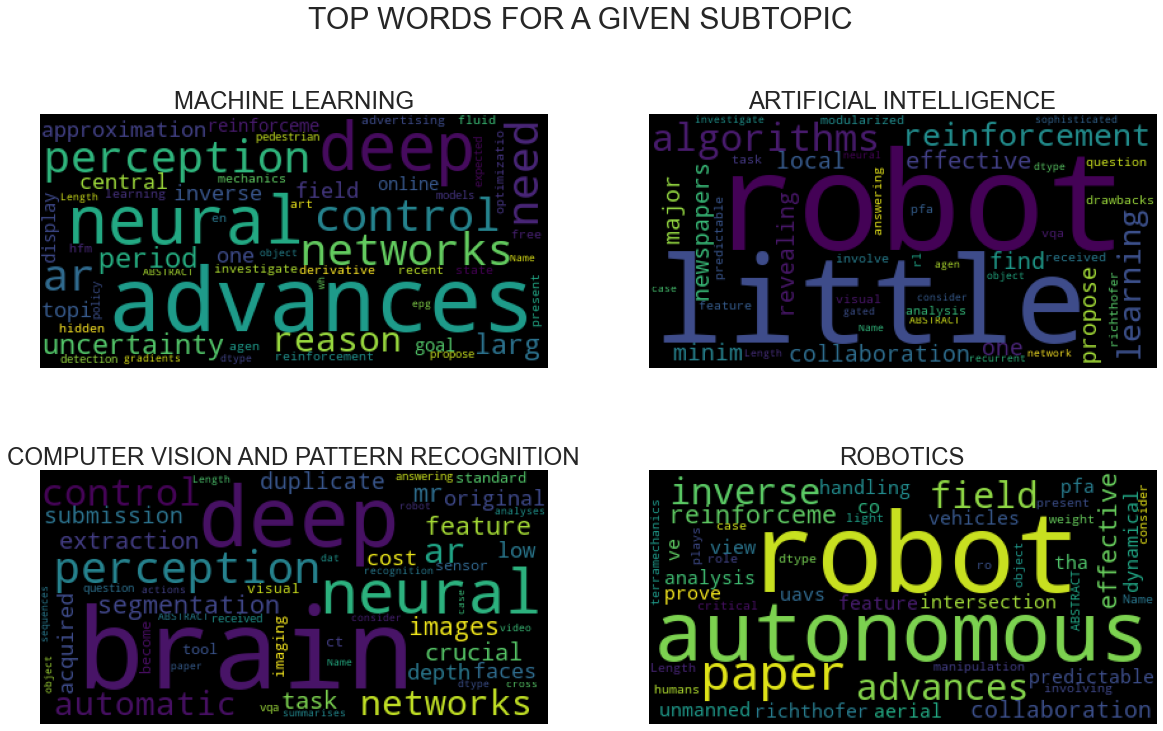

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(['Machine Learning', 'Artificial Intelligence', 'Computer Vision and Pattern Recognition', 'Robotics']):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN SUBTOPIC', fontsize=30)

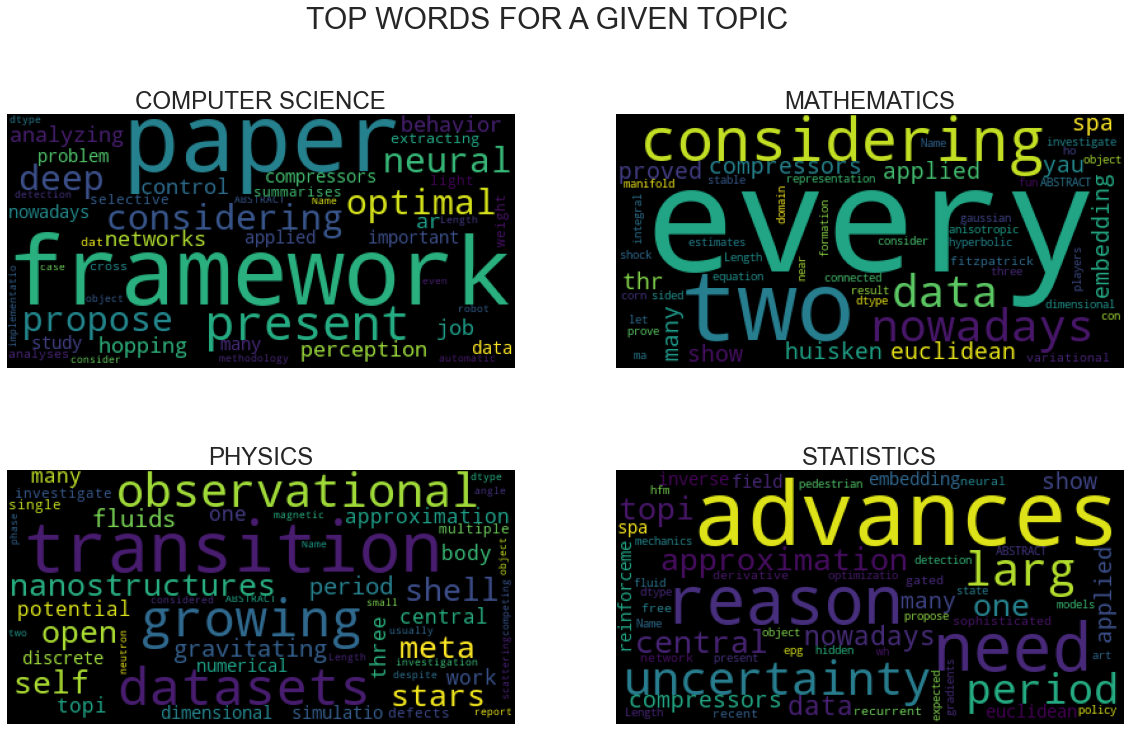

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = [ax for axes_row in axes for ax in axes_row]
for i, sub_topic_name in enumerate(TOPIC_COLS):
  sub_topic = train[train[sub_topic_name] == 1]
  op = wc.generate(str(sub_topic['ABSTRACT']))
  _ = axes[i].imshow(op)
  _ = axes[i].set_title(sub_topic_name.upper(), fontsize=24)
  _ = axes[i].axis('off')
_ = plt.suptitle('TOP WORDS FOR A GIVEN TOPIC', fontsize=30)

# **MODEL BUILDING**

## **Bag of Words Approach**

In [20]:
# make all text lowercase
def text_lowercase(text):
    return text.lower()

# remove punctuation
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

# tokenize
def tokenize(text):
    text = word_tokenize(text)
    return text

# remove stopwords
stop_words = set(stopwords.words('english'))
def remove_stopwords(text):
    text = [i for i in text if not i in stop_words]
    return text

# lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    text = [lemmatizer.lemmatize(token) for token in text]
    return text

In [21]:
def preprocessing(text):
    text = text_lowercase(text)
    text = remove_punctuation(text)
    text = tokenize(text)
    text = remove_stopwords(text)
    text = lemmatize(text)
    text = ' '.join(text)
    return text 

In [22]:
train['ABSTRACT'] = train['ABSTRACT'].apply(preprocessing)
test['ABSTRACT'] = test['ABSTRACT'].apply(preprocessing)

In [23]:
# train data is split into train and validation sets
X_train,X_val,Y_train,Y_val = train_test_split(train.iloc[:,1:6],train.loc[:,TARGET_COLS],test_size=0.2,random_state = 101)

In [24]:
X_train
X_val
Y_train
Y_val

,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
5660,article present framework develops formulation...,1,1,0,0
3335,interaction thin viscous film elastic sheet re...,0,0,1,0
13238,inside paper investigate convection phenomenon...,0,0,1,0
5227,update rule considering learning inside dynami...,1,0,0,1
260,modern scientific instrument produce vast amou...,0,0,0,1
...,...,...,...,...,...
5695,catastrophic forgetting significant negative i...,1,0,0,0
8006,consider class evolution equation describe pse...,0,1,0,0
1361,bot playing crucial role inside online platfor...,1,0,0,0
1547,bilinear matrix inequality bmi problem inside ...,1,0,0,0


,ABSTRACT,Computer Science,Mathematics,Physics,Statistics
1423,consider initial value problem associated neur...,0,1,0,0
8947,tactile sensor technology made great stride pa...,1,0,0,0
9275,inside paper solve simultaneous diophantine eq...,0,1,0,0
5362,network representation complex underlying soci...,1,0,0,0
2351,herbertsmithite zndoped barlowite two compound...,0,0,1,0
...,...,...,...,...,...
10857,last decade witness significant methodological...,0,1,0,1
8646,interested inside development surrogate model ...,0,0,0,1
7388,action recognition attracted increasing attent...,0,0,0,1
9937,dependence quasisaturation generalized pauli c...,0,0,1,0


,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
5660,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
3335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13238,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5227,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5695,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8006,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1361,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1547,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


,Analysis of PDEs,Applications,Artificial Intelligence,Astrophysics of Galaxies,Computation and Language,Computer Vision and Pattern Recognition,Cosmology and Nongalactic Astrophysics,Data Structures and Algorithms,Differential Geometry,Earth and Planetary Astrophysics,...,Methodology,Number Theory,Optimization and Control,Representation Theory,Robotics,Social and Information Networks,Statistics Theory,Strongly Correlated Electrons,Superconductivity,Systems and Control
1423,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8947,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9275,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5362,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2351,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10857,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
8646,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7388,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9937,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
# Utility function to obtain the best thresholds for predicted probability
def get_best_thresholds(true, preds):
    thresholds = [i/100 for i in range(100)]
    best_thresholds = []
    for idx in range(25):
        f1_scores = [f1_score(true[:, idx], (preds[:, idx] > thresh) * 1) for thresh in thresholds]
        best_thresh = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_thresh)
    return best_thresholds

In [26]:
tfidf = TfidfVectorizer(max_features=10000)
tfidf.fit(list(train["ABSTRACT"])+list(test["ABSTRACT"]))


train_data = tfidf.transform(X_train["ABSTRACT"])
val_data = tfidf.transform(X_val["ABSTRACT"])
test_data = tfidf.transform(test["ABSTRACT"])

TfidfVectorizer(max_features=10000)

In [27]:
train_data = csr_matrix(np.concatenate((train_data.toarray(),X_train.loc[:,TOPIC_COLS]),axis=1).astype('float32'))
val_data = csr_matrix(np.concatenate((val_data.toarray(),X_val.loc[:,TOPIC_COLS]),axis=1).astype('float32'))
test_data = csr_matrix(np.concatenate((test_data.toarray(),test.loc[:,TOPIC_COLS]),axis=1).astype('float32'))

In [12]:
clf_lgb = OneVsRestClassifier(LGBMClassifier(
                    objective='binary',
                    verbose=3,
                    ))

In [13]:
# Create the parameter grid
param_grid = {'estimator__n_estimators': [100,200,300], 'estimator__max_depth': [1,5,10,15,20]} 

In [15]:
grid_clf_lgb = GridSearchCV(
    estimator=clf_lgb,
    param_grid=param_grid,
    scoring='f1_micro',
    n_jobs=-1,
    cv=5,
    refit=True, return_train_score=True)
print(grid_clf_lgb)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LGBMClassifier(objective='binary',
                                                                    verbose=3)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [1, 5, 10, 15, 20],
                         'estimator__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='f1_micro')


In [16]:
grid_clf_lgb.fit(train_data,Y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 485, number of negative: 10718
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.986502
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.986040
[LightGBM] [Debug] init for col-wise cost 0.084078 seconds, init for row-wise cost 0.087315 seconds
[LightGBM] [Debug] col-wise cost 0.012684 seconds, row-wise cost 0.012693 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.112692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 203651
[LightGBM] [Info] Number of data points in the train set: 11203, number of used features: 4553
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.043292 -> initscore=-3.095531
[LightGBM] [

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number o

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Warning]

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 21 and max_depth = 17
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 14
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and max_depth = 13
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and max_depth = 11
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 20 and max_depth = 15
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 19 and 

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 15
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 14
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 12
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Info] Number of positive: 503, number of negative: 10700
[LightGBM] [Debug] Dataset:

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 17
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 16
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and max_depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and max_depth = 6
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and max_depth = 7
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and max_depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 11 and max_depth = 8
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Debug] Trained a tree with leaves = 10 and max_de

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 18
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] Trained a tree with leaves = 31 and max_depth = 20
[LightGBM] [Debug] T

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LGBMClassifier(objective='binary',
                                                                    verbose=3)),
             n_jobs=-1,
             param_grid={'estimator__max_depth': [1, 5, 10, 15, 20],
                         'estimator__n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='f1_micro')

In [17]:
best_estimators = grid_clf_lgb.best_params_
print(best_estimators)

{'estimator__max_depth': 20, 'estimator__n_estimators': 200}


In [18]:
val_preds = grid_clf_lgb.predict_proba(val_data)
best_thresholds = get_best_thresholds(Y_val.values,val_preds)

for i, thresh in enumerate(best_thresholds):
    val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(Y_val.values,val_preds,average='micro')

0.7560511975668484

In [31]:
test_preds = grid_clf_lgb.predict_proba(test_data)
sub = pd.DataFrame(test_preds,columns=list(TARGET_COLS)).astype(int)
for i, thresh in enumerate(best_thresholds):
    test_preds[:, i] = (test_preds[:, i] > thresh) * 1
sub = pd.DataFrame(test_preds,columns=list(TARGET_COLS)).astype(int)
ss.iloc[:,1:] = sub.values

ss.to_csv('./submission10_HT.csv',index=False)
#0.73905429071803s

In [37]:
clf_logreg = OneVsRestClassifier(LogisticRegression())

In [43]:
# Create the parameter grid
estimator__solvers = ['newton-cg', 'lbfgs', 'liblinear','sag']
estimator__penalty = ['l2']
estimator__c_values = [100, 10, 5, 1.0, 0.1, 0.01]

param_grid = {'estimator__solver': ['newton-cg', 'lbfgs', 'liblinear','sag'], 'estimator__penalty': ['l2','l1'], 'estimator__C': [100, 10, 5, 1.0, 0.1, 0.01]} 

In [44]:
grid_clf_log = GridSearchCV(
    estimator=clf_logreg,
    param_grid=param_grid,
    scoring='f1_micro',
    n_jobs=-1,
    cv=5,
    refit=True, return_train_score=True)
print(grid_clf_log)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 5, 1.0, 0.1, 0.01],
                         'estimator__penalty': ['l2', 'l1'],
                         'estimator__solver': ['newton-cg', 'lbfgs',
                                               'liblinear', 'sag']},
             return_train_score=True, scoring='f1_micro')


In [45]:
grid_clf_log.fit(train_data,Y_train)

GridSearchCV(cv=5,
             estimator=OneVsRestClassifier(estimator=LogisticRegression()),
             n_jobs=-1,
             param_grid={'estimator__C': [100, 10, 5, 1.0, 0.1, 0.01],
                         'estimator__penalty': ['l2', 'l1'],
                         'estimator__solver': ['newton-cg', 'lbfgs',
                                               'liblinear', 'sag']},
             return_train_score=True, scoring='f1_micro')

In [47]:
best_estimators = grid_clf_log.best_params_
print(best_estimators)

{'estimator__C': 100, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}


In [48]:
val_preds = grid_clf_log.predict_proba(val_data)
best_thresholds = get_best_thresholds(Y_val.values,val_preds)

for i, thresh in enumerate(best_thresholds):
    val_preds[:, i] = (val_preds[:, i] > thresh) * 1

f1_score(Y_val.values,val_preds,average='micro')

0.7627658219788617

In [49]:
test_preds = grid_clf_log.predict_proba(test_data)
sub = pd.DataFrame(test_preds,columns=list(TARGET_COLS)).astype(int)
for i, thresh in enumerate(best_thresholds):
    test_preds[:, i] = (test_preds[:, i] > thresh) * 1
sub = pd.DataFrame(test_preds,columns=list(TARGET_COLS)).astype(int)
ss.iloc[:,1:] = sub.values

ss.to_csv('./submission11_LG_HT.csv',index=False)
#0.7414452397293853